In [43]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
import tensorflow as tf


In [44]:
(x,y),(x1,y1)=tf.keras.datasets.cifar10.load_data()
print(x.shape,x1.shape)
x=x[y.flatten()==8]
x.shape

(50000, 32, 32, 3) (10000, 32, 32, 3)


(5000, 32, 32, 3)

In [45]:
# define parameters to be used in later processes 
image_shape=(32,32,3)
latent_dimensions = 100


# define a utility function to build the generator 

In [46]:
def build_generator():
    model=Sequential([
        Dense(128*8*8, activation='relu', input_dim=latent_dimensions),
        Reshape((8,8,128)),
        UpSampling2D(),

        Conv2D(128,kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(momentum=0.78),
        UpSampling2D(),
        
        Conv2D(64, kernel_size=3, padding='same', activation='tanh'),
        BatchNormalization(momentum=0.78),

        Conv2D(3, kernel_size=3, padding='same', activation='tanh'),
        

    ])
    noise=Input(shape=(latent_dimensions,))
    image=model(noise)
    return Model(noise, image)

# Define a utility function to build the discriminator 

In [47]:
def build_discriminator():
    model=Sequential([
        
        Conv2D(32, kernel_size=3, strides=2, input_shape=input_shape, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),

        Conv2D(64, kernel_size=3, strides=2, padding='same'),
        ZeroPadding2D(padding=((0,1),(0,1))),
        BatchNormalization(momentum=0.82),
        LeakyReLU(alpha=0.25),
        Dropout(0.25),

        Conv2D(128,kernel_size=3, strides=2, padding='same'),
        BatchNormalization(momentum=0.82),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),

        Conv2D(255,kernel_size=3, strides=2, padding='same'),
        BatchNormalization(momentum=0.82),
        LeakyReLU(alpha=0.25),
        Dropout(0.25),


        Flatten(),
        Dense(1,activation='sigmoid')
        
    ])

    image=Input(shape=image_shape)
    validity=model(image)

    return Model(image, validity)
    

# Define a utility function to display the generated images 

In [48]:
def display_images():
    r,c=4,4
    noise=np.random.normal(0,1, (r*c,latent_dimensions))
    generated_images=generator.predict(noise)
   
    generated_images=0.5*generated_images+0.5
    fig,axs=plt.subplots(r,c)
    count=0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(generated_images[count,:,:,])
            axs[i,j].axis('off')
            count+=1
    plt.show()
    plt.close()

# Building the generative Adversarial Network

In [33]:
discriminator=build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5), metrics=['accuracy'])
#making the discriminator untrainable so that the generator can learn from fixed gradient 
discriminator.trainable=False
#building the generator
generator=build_generator()

#defining the input for the generator and generating the images 
z= Input(shape=(latent_dimensions,))
image=generator(z)

#Checking the validity of the generated image 
valid = discriminator(image)

#defining the combined model of the generator and the discriminator 
combined_network = Model(z,valid)
combined_network.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

# Train the network

1/1 [==============================] - 0s 24ms/step


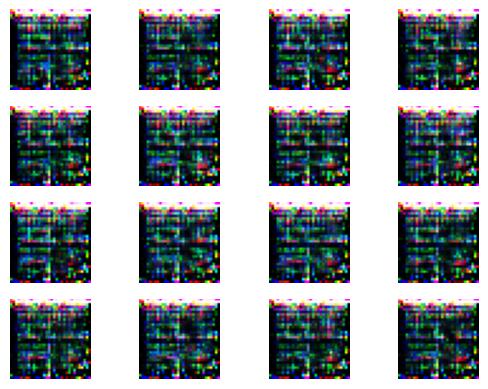

1/1 [==============================] - 0s 15ms/step


KeyboardInterrupt: 

In [49]:
num_epochs=15000
batch_size=32
display_interval=2500
losses=[] 
  
#Normalizing the input 
x = (x / 127.5) - 1.
          
  
#Defining the Adversarial ground truths 
valid = np.ones((batch_size, 1)) 
  
#Adding some noise  
valid += 0.05 * np.random.random(valid.shape) 
fake = np.zeros((batch_size, 1)) 
fake += 0.05 * np.random.random(fake.shape) 
  
for epoch in range(num_epochs): 
              
            #Training the Discriminator 
              
            #Sampling a random half of images 
            index = np.random.randint(0, x.shape[0], batch_size) 
            images = x[index] 
  
            #Sampling noise and generating a batch of new images 
            noise = np.random.normal(0, 1, (batch_size, latent_dimensions)) 
            generated_images = generator.predict(noise) 
              
  
            #Training the discriminator to detect more accurately 
            #whether a generated image is real or fake 
            discm_loss_real = discriminator.train_on_batch(images, valid) 
            discm_loss_fake = discriminator.train_on_batch(generated_images, fake) 
            discm_loss = 0.5 * np.add(discm_loss_real, discm_loss_fake) 
              
            #Training the Generator 
  
            #Training the generator to generate images 
            #which pass the authenticity test 
            genr_loss = combined_network.train_on_batch(noise, valid) 
              
            #Tracking the progress                 
            if epoch % display_interval == 0: 
                 display_images() 